# BBM92 Quantum Key Distribution Simulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import math
from ThOPqkdsim.simBBM92 import *

<div style="text-align: center;">
    <img src="Figures/BBM92/diagram-BBM92.png" width="800">
</div>

## 1. Introduction

Quantum Key Distribution (QKD) enables secure communication by leveraging quantum mechanics principles. The BBM92 protocol is a popular implementation of QKD that uses entangled photons. 

This simulator models the BBM92 protocol using Type-II Spontaneous Parametric Down-Conversion (SPDC) photon sources, quantum channels, and single-photon detectors.


<div style="text-align: center;">
    <img src="Figures/BBM92/QKD_sim-BBM92-steps.png" width="350">
</div>

## 2. Photon Source

### Class: `PhotonSource`

The `PhotonSource` class simulates a Type-II SPDC photon source, which generates entangled photon pairs.

#### Key Functions and Variables

- **`__init__(mu)`**: Initializes the photon source with mean photon number `mu`.
  - `mu` (float): Mean photon number per pulse.

- **`photon_distribution(n_max=20)`**: Calculates the photon number distribution \( P_S(n) \) up to `n_max`.
  - Returns: `np.array` - Probability distribution of photon numbers.

   $P_S(n) = (n+1) \cdot \left( \frac{\mu}{2} \right)^n \Big/ \left( 1 + \frac{\mu}{2} \right)^{n+2}$

  -  Where:
    - $ P_S(n)$: P emitting exrobability ofactly $ n $ photon pairs in a single pulse.
    - $ \mu $: Mean photon number per pulse.  

In [2]:
class PhotonSource:
    """
    Simulates a Type-II SPDC photon source with photon number distributions.
    """
    def __init__(self, mu):
        """
        Initialize the photon source with mean photon number mu.
        
        Args:
            mu (float): Mean photon number per pulse
        """
        self.mu = mu
    
    def photon_distribution(self, n_max=20):
        """
        Calculate the photon number distribution PS(n) up to n_max.
        
        Returns:
            np.array: Probability distribution of photon numbers
        """
        n_values = np.arange(n_max + 1)
        p_s = (n_values + 1) * ((self.mu/2)**n_values) / ((1 + (self.mu/2))**(n_values + 2))
        return p_s


## 3. Channel

### Class: `Channel`

The `Channel` class represents the quantum channel between the photon source and the receiver (Alice/Bob). It models distance-dependent attenuation and supports both fiber optic and free space optical (FSO) communication modes.

#### Key Functions and Variables

- **`__init__(base_efficiency, distance=0, attenuation=0.2, mode="fiber")`**: Initializes the channel.
  - `base_efficiency` (float): Base transmission efficiency (0–1).
  - `distance` (float): Channel distance in kilometers.
  - `attenuation` (float): Fiber attenuation coefficient in dB/km.
  - `mode` (str): Channel mode - "fiber" or "fso".

- **`calculate_efficiency()`**: Calculates actual channel efficiency based on distance and mode.
  - Returns: `float` - Channel efficiency after attenuation.

- **`update_distance(distance)`**: Updates the channel distance and recalculates efficiency.

- **`update_mode(mode)`**: Updates the channel mode ("fiber" or "fso") and recalculates efficiency.

- **`set_fso_parameters(...)`**: Sets FSO-specific parameters like transmitter/receiver diameters, beam divergence, etc.

- **`transmission_probability(sent_photons, received_photons)`**: Calculates the probability of receiving photons given sent photons.
  - Uses binomial probability.

- **`calculate_misalignment_error()`**: Calculates optical misalignment error based on distance.

### 3.1 Fiber Optic Channel

#### 3.1.1 Channel Attenuation

The **attenuation** of a fiber optic channel is typically measured in decibels per kilometer (dB/km). For a fiber of length $ d $ (in kilometers) and attenuation coefficient $\alpha $ (in dB/km), the total attenuation in decibels is:

$
A_\text{dB} = \alpha \cdot d
$

#### 3.1.2 Fiber Channel Transmission Efficiency

The **transmission efficiency** $ \eta_{\text{channel}} $ for fiber optic channels represents the probability that a photon successfully passes through the channel. It is given by:

$
\eta_{\text{channel}} = 10^{-\frac{A_\text{dB}}{10}} = 10^{-\frac{\alpha \cdot d}{10}}
$

- $ \alpha $: Attenuation coefficient in dB/km.
- $ d $: Channel length in km.

With a **base efficiency** (accounting for coupling losses, imperfect optics), the total efficiency becomes:

$
\eta_{\text{total}} = \eta_{\text{base}} \cdot \eta_{\text{channel}} = \eta_{\text{base}} \cdot 10^{-\frac{\alpha \cdot d}{10}}
$

Where:
- $ \eta_{\text{base}} $: The base transmission efficiency (without distance loss).

### 3.2 Free Space Optical (FSO) Channel

#### 3.2.1 FSO Channel Parameters

The FSO channel model includes several parameters that affect its performance:

- `transmitter_diameter`: Diameter of transmitter aperture (m)
- `receiver_diameter`: Diameter of receiver aperture (m)
- `beam_divergence`: Beam divergence angle (radians)


#### 3.2.2 FSO Channel Transmission Efficiency

The FSO channel efficiency is modeled with several contributing factors:

### 1. **Base Efficiency**

This refers to the **intrinsic efficiency** of the transmitter/receiver pair, denoted as $\eta_0$.

---

### 2. **Geometrical Loss Factor**

As the optical beam propagates, it **diverges** and spreads out. The receiver captures only a portion of the beam, depending on its aperture size relative to the spot size at the receiver.

- **Transmitter diameter:** $D_t$
- **Receiver diameter:** $D_r$
- **Beam divergence angle (rad):** $\theta$
- **Distance between transmitter and receiver (km):** $d$

**Beam diameter at receiver:**
$
D_\text{recv} = D_t + (d \times 1000) \times \theta
$

**Geometrical efficiency factor:**
$
\eta_\text{geo} = (\frac{D_r}{D_\text{recv}})^2
$

---

### 3. **Atmospheric Attenuation Factor**

Atmospheric conditions (fog, rain, dust) cause **exponential attenuation** of the optical signal.

- **Atmospheric attenuation coefficient (dB/km):** $\alpha$

**Atmospheric loss:**
$
\eta_\text{atm} = \exp(-\alpha d)
$

---

### 4. **Total Channel Efficiency**

The overall FSO channel efficiency is the product of all factors, **clamped** to the range $[0,1]$:

$
\eta_\text{FSO} = \eta_0 \times \eta_\text{geo} \times \eta_\text{atm}
$

where:
- $\eta_0$ = base efficiency,
- $\eta_\text{geo}$ = geometrical loss factor,
- $\eta_\text{atm}$ = atmospheric loss factor.

---

### 3.3 Probability of Photon Transmission

For both fiber and FSO channels, if $ n_{\text{sent}} $ photons are sent, the probability of receiving exactly $ n_{\text{rec}} $ photons follows a binomial distribution:

$
P(n_{\text{rec}} \mid n_{\text{sent}}, \eta_{\text{total}}) = \binom{n_{\text{sent}}}{n_{\text{rec}}} \cdot \eta_{\text{total}}^{n_{\text{rec}}} \cdot (1 - \eta_{\text{total}})^{n_{\text{sent}} - n_{\text{rec}}}
$

Where:
- $ P(n_{\text{rec}} \mid n_{\text{sent}}, \eta_{\text{total}}) $: Probability to receive $ n_{\text{rec}} $ photons out of $ n_{\text{sent}} $.
- $ \binom{n_{\text{sent}}}{n_{\text{rec}}} $: Binomial coefficient.
- $ \eta_{\text{total}} $: Total channel efficiency (either fiber or FSO, depending on mode).

### 3.4 Misalignment Error

The optical misalignment error increases with distance but saturates at a maximum value:

$
\text{misalignment\_error} = \min(0.1, \text{misalignment\_base} + \text{misalignment\_factor} \cdot d)
$

Where:
- $\text{misalignment\_base}$: Base misalignment error (default: 0.015 or 1.5%)
- $\text{misalignment\_factor}$: Rate of increase per km (default: 0.0002)
- $d$: Distance (km)

In [3]:
class Channel:
    """
    Represents the quantum channel between Alice and Bob.
    Includes both fiber and FSO (Free Space Optical) channel modeling options.
    """
    def __init__(self, base_efficiency, distance=0, attenuation=0.2, mode="fiber"):
        """
        Initialize the channel with distance-dependent efficiency.
        
        Args:
            base_efficiency (float): Base channel transmission efficiency without distance (0-1)
            distance (float): Channel distance in kilometers
            attenuation (float): Fiber attenuation coefficient in dB/km
            mode (str): Channel mode - "fiber" or "fso"
        """
        self.base_efficiency = base_efficiency
        self.distance = distance
        self.attenuation = attenuation
        
        # FSO specific parameters with default values
        self.transmitter_efficiency = 0.9  # Efficiency of transmitter optics
        self.receiver_efficiency = 0.9     # Efficiency of receiver optics
        self.transmitter_diameter = 0.1    # Diameter of transmitter aperture in meters
        self.receiver_diameter = 0.3       # Diameter of receiver aperture in meters
        self.beam_divergence = 0.001       # Beam divergence angle in radians (1 mrad)
        self.wavelength = 850e-9           # Wavelength in meters (850 nm)
        self.pointing_error = 1e-6         # Pointing error in radians
        
        # Optical misalignment that increases with distance
        self.misalignment_base = 0.015     # 1.5% base misalignment error
        self.misalignment_factor = 0.0002  # Increase per km
        
        # Set mode and calculate efficiency
        self.mode = mode
        self.efficiency = self.calculate_efficiency()
    
    def calculate_efficiency(self):
        """
        Calculate the actual channel efficiency based on distance and mode.
        
        Returns:
            float: Actual channel efficiency after distance attenuation
        """
        if self.mode == "fiber":
            return self._calculate_fiber_efficiency()
        elif self.mode == "fso":
            return self._calculate_fso_efficiency()
        else:
            raise ValueError(f"Unknown channel mode: {self.mode}")
    
    def _calculate_fiber_efficiency(self):
        """
        Calculate efficiency for fiber optic channel.
        
        Returns:
            float: Channel efficiency for fiber
        """
        # Calculate attenuation in dB
        attenuation_db = self.distance * self.attenuation
        
        # Convert to transmission efficiency: 10^(-attenuation_db/10)
        distance_factor = 10**(-attenuation_db/10)
        
        # Total efficiency is base efficiency times distance factor
        return self.base_efficiency * distance_factor
    
    def _calculate_fso_efficiency(self):
        """
        Calculate efficiency for FSO channel based on provided model.
        
        Returns:
            float: Channel efficiency for FSO
        """
        # For zero distance, return direct efficiency without atmospheric effects
        if self.distance <= 1e-6:  # Effectively zero
            return self.base_efficiency * self.transmitter_efficiency * self.receiver_efficiency
    
        # Calculate geometrical loss factor
        beam_diameter_at_receiver = self.transmitter_diameter + (self.distance * 1000 * self.beam_divergence)
        geo_factor = min(1.0, (self.receiver_diameter / beam_diameter_at_receiver)**2)
        
        # Calculate simplified turbulence-induced scintillation loss
        # Using a simplified model based on distance
        turb_factor = np.exp(-0.05 * self.distance)  # Simplified exponential decay with distance
        
        # Calculate simplified beam wandering effect
        # Increases with distance
        pointing_variance = (self.pointing_error * self.distance * 1000)**2
        beam_spot_size = (self.beam_divergence * self.distance * 1000 / 2)**2
        bw_factor = np.exp(-2 * pointing_variance / beam_spot_size)
        
        # Calculate overall transmission efficiency
        total_efficiency = (self.base_efficiency * geo_factor * self.transmitter_efficiency * 
                            self.receiver_efficiency * turb_factor * bw_factor)
        
        return min(1.0, max(0.0, total_efficiency))  # Ensure efficiency is between 0 and 1
    
    def update_distance(self, distance):
        """
        Update the channel distance and recalculate efficiency.
        
        Args:
            distance (float): New channel distance in kilometers
        """
        self.distance = distance
        self.efficiency = self.calculate_efficiency()
    
    def update_mode(self, mode):
        """
        Update the channel mode and recalculate efficiency.
        Default FSO parameters are automatically used when switching to FSO mode.
        
        Args:
            mode (str): New channel mode ("fiber" or "fso")
        """
        if mode not in ["fiber", "fso"]:
            raise ValueError(f"Unsupported channel mode: {mode}. Use 'fiber' or 'fso'.")
            
        self.mode = mode
        self.efficiency = self.calculate_efficiency()
    
    def set_fso_parameters(self, transmitter_diameter=None, receiver_diameter=None, 
                          beam_divergence=None, wavelength=None, pointing_error=None,
                          transmitter_efficiency=None, receiver_efficiency=None):
        """
        Update FSO-specific parameters. Only updates the parameters that are provided.
        
        Args:
            transmitter_diameter (float, optional): Diameter of transmitter aperture in meters
            receiver_diameter (float, optional): Diameter of receiver aperture in meters
            beam_divergence (float, optional): Beam divergence angle in radians
            wavelength (float, optional): Wavelength in meters
            pointing_error (float, optional): Pointing error in radians
            transmitter_efficiency (float, optional): Efficiency of transmitter optics
            receiver_efficiency (float, optional): Efficiency of receiver optics
        """
        if transmitter_diameter is not None:
            self.transmitter_diameter = transmitter_diameter
        if receiver_diameter is not None:
            self.receiver_diameter = receiver_diameter
        if beam_divergence is not None:
            self.beam_divergence = beam_divergence
        if wavelength is not None:
            self.wavelength = wavelength
        if pointing_error is not None:
            self.pointing_error = pointing_error
        if transmitter_efficiency is not None:
            self.transmitter_efficiency = transmitter_efficiency
        if receiver_efficiency is not None:
            self.receiver_efficiency = receiver_efficiency
            
        # Recalculate efficiency if in FSO mode
        if self.mode == "fso":
            self.efficiency = self.calculate_efficiency()
    
    def transmission_probability(self, sent_photons, received_photons):
        """
        Calculate probability of receiving photons given sent photons.
        
        Args:
            sent_photons (int): Number of photons sent
            received_photons (int): Number of photons received
            
        Returns:
            float: Probability of receiving the specified number of photons
        """
        if received_photons > sent_photons:
            return 0.0
        
        return binom.pmf(received_photons, sent_photons, self.efficiency)
    
    def calculate_misalignment_error(self):
        """
        Calculate optical misalignment error based on distance.
        
        Returns:
            float: Misalignment error probability (0-1)
        """
        # Error increases with distance but saturates
        return min(0.1, self.misalignment_base + self.misalignment_factor * self.distance)

## 4. Detector

### Class: `Detector`

The `Detector` class models a single-photon detector with efficiency and noise characteristics.

#### Key Functions and Variables

- **`__init__(efficiency, dark_count_rate, time_window)`**: Initializes the detector with efficiency, dark count rate, and time window.
  - `efficiency` (float): Detection efficiency (0–1).
  - `dark_count_rate` (float): Dark count rate in counts per second.
  - `time_window` (float): Detection time window in seconds.

- **`detect_probability(photons)`**: Calculates the probability of detecting photons.
  - Returns: `float` - Detection probability.

### 4.1 Quantum Efficiency

Let $ \eta_{\mathrm{det}} $ denote the quantum efficiency of the detector (the probability that an incoming photon is detected).

If $ n $ photons arrive at the detector, the probability of detecting **at least one** photon (i.e., the detector "clicks") is:

$
P_{\mathrm{detect}}(n) = 1 - (1 - \eta_{\mathrm{det}})^n
$

- If $ n = 0 $, then $ P_{\mathrm{detect}}(0) = 0 $.

---

### 4.2 Dark Count Probability

The **dark count rate** $ D $ is the average number of false counts per second due to detector noise. For a measurement window of duration $ \Delta t $, the probability of a dark count (i.e., the detector clicks even when no photon arrives) is:

$
P_{\mathrm{dark}} = 1 - e^{-D \Delta t}
$

---

### 4.3 Total Detection Probability

If both true photons and dark counts are possible, the total probability that the detector clicks is:

$
P_{\mathrm{click}} = 1 - (1 - P_{\mathrm{detect}}(n))(1 - P_{\mathrm{dark}})
$

This expresses the probability that **either** a real photon is detected, **or** a dark count occurs, **or both**.


In [4]:
class Detector:
    """
    Represents a single-photon detector with noise characteristics.
    """
    def __init__(self, efficiency, dark_count_rate, time_window):
        """
        Initialize detector with its characteristics.
        
        Args:
            efficiency (float): Detector efficiency (0-1)
            dark_count_rate (float): Dark count rate in counts per second
            time_window (float): Detection time window in seconds
        """
        self.efficiency = efficiency
        self.dark_count_rate = dark_count_rate
        self.time_window = time_window
        self.p_noise = 1 - np.exp(-dark_count_rate * time_window)
    
    def detect_probability(self, photons):
        """
        Calculate the probability of detection given number of photons.
        
        Args:
            photons (int): Number of photons arriving at detector
            
        Returns:
            float: Probability of detection
        """
        # Probability of at least one photon being detected
        if photons > 0:
            # 1 - probability that none are detected
            return 1 - (1 - self.efficiency)**photons
        return 0

# 5. BBM92 Simulator

## Class: `BBM92Simulator`

The `BBM92Simulator` class integrates the photon source, channels, and detectors to simulate the BBM92 QKD protocol. It supports both fiber optic and free space optical (FSO) communication channels.

## Class Functions and Variables

### 1. **`__init__()`**
   - Initializes the simulator with parameters such as mean photon number, detector efficiencies, channel efficiencies, dark count rate, distance, and channel mode.
   - **New parameter**: `channel_mode` ("fiber" or "fso") determines the type of quantum channel used.

### 2. `update_distance`

**Purpose:**  
Updates the channel distance and recalculates the channel transmission efficiency.

**Mathematical Equation:**  
For new distance \( d \), the channel efficiency is updated based on the channel mode:

For fiber mode:
$
\eta_{\mathrm{channel}} = \eta_{\mathrm{base}} \cdot 10^{-\frac{\alpha d}{10}}
$

For FSO mode (simplified):
$
\eta_{\mathrm{channel}} = \eta_{\mathrm{base}} \cdot \eta_{\mathrm{geo}} \cdot \eta_{\mathrm{tx}} \cdot \eta_{\mathrm{rx}} \cdot \eta_{\mathrm{turb}} \cdot \eta_{\mathrm{bw}}
$

where  
\( \eta_{\mathrm{base}} \) = base channel efficiency  
\( \alpha \) = attenuation coefficient (dB/km)  
\( d \) = distance (km)

---

### 3. `update_mu`

**Purpose:**  
Updates the mean photon number \( \mu \) for the photon source.

- No mathematical operation; simply updates the source parameter.

---

### 4. `update_channel_mode`

**Purpose:**  
Updates the channel mode ("fiber" or "fso") for both Alice and Bob channels.

- Switches between fiber optic and free space optical communication models.
- Recalculates channel efficiencies based on the new mode.

---

### 5. `set_fso_parameters`

**Purpose:**  
Sets FSO-specific parameters for both Alice and Bob channels when using "fso" mode.

**Parameters:**
- `transmitter_diameter`: Diameter of transmitter aperture (m)
- `receiver_diameter`: Diameter of receiver aperture (m)
- `beam_divergence`: Beam divergence angle (radians)
- `wavelength`: Wavelength (m)
- `pointing_error`: Pointing error (radians)
- `transmitter_efficiency`: Efficiency of transmitter optics
- `receiver_efficiency`: Efficiency of receiver optics

---

### 6. `calculate_joint_probabilities`

**Purpose:**  
Calculates joint probabilities for emitting \( l \) photon pairs, with Alice receiving \( \alpha \) photons and Bob receiving \( \beta \) photons, with detection included.

#### Steps:

1. **Photon Source Probability:**  
$
P_S(l) = (l + 1) \left( \frac{\mu}{2} \right)^l \left( 1 + \frac{\mu}{2} \right)^{-(l+2)}
$

2. **Channel Transmission Probabilities:**  
- Alice:  
$
P_{A,\mathrm{chan}} = \binom{l}{\alpha} \eta_{A}^{\alpha} (1-\eta_{A})^{l-\alpha}
$
- Bob:  
$
P_{B,\mathrm{chan}} = \binom{l}{\beta} \eta_{B}^{\beta} (1-\eta_{B})^{l-\beta}
$

3. **Detection Probabilities:**  
- Alice:  
$
P_{A,\mathrm{det}} = 1 - (1 - \eta_{A,\mathrm{det}})^{\alpha}
$
- Bob:  
$
P_{B,\mathrm{det}} = 1 - (1 - \eta_{B,\mathrm{det}})^{\beta}
$

4. **Joint Probability:**  
$
P(l, \alpha, \beta) = P_S(l) \cdot P_{A,\mathrm{chan}} \cdot P_{B,\mathrm{chan}} \cdot P_{A,\mathrm{det}} \cdot P_{B,\mathrm{det}}
$

---

### 7. `calculate_p_rec`

**Purpose:**  
Calculates the probability that both Alice and Bob's detectors record a click (coincidence).

#### Main Terms:

- **Both signal:**  
$
P_{\mathrm{both,signal}} = \sum_{l>0,\,\alpha>0,\,\beta>0} P(l, \alpha, \beta)
$

- **Noise probabilities:**  
Let \( p_{A,n} \) and \( p_{B,n} \) be the dark count probabilities for Alice and Bob, respectively.

$
p_{A,n,4} = 1 - (1 - p_{A,n})^4 \\
p_{B,n,4} = 1 - (1 - p_{B,n})^4
$

- **Cross terms:**  
Alice noise, Bob signal:
$
\sum_{l=1}^{n_{\max}} \sum_{\beta=1}^{l} P_{B,\mathrm{det}} \cdot p_{A,n,4} \cdot P_{B,\mathrm{chan}} \cdot P_{A,\mathrm{chan}}(l,0) \cdot P_S(l)
$

Alice signal, Bob noise: (analogous)

- **Both noise:**  
$
P_{\mathrm{both,noise}} = p_{A,n,4} \cdot p_{B,n,4}
$

- **Total:**  
$
P_{\mathrm{rec}} = P_{\mathrm{both,signal}} + P_{\mathrm{A,noise,B,signal}} + P_{\mathrm{A,signal,B,noise}} + P_{\mathrm{both,noise}}
$

---

### 8. `calculate_p_key`

**Purpose:**  
Calculates the probability that a bit is recorded and used in the key (basis reconciliation applied).

$
P_{\mathrm{key}} = \frac{1}{2} P_{\mathrm{rec}}
$

---

### 9. `calculate_p_signal`

**Purpose:**  
Calculates the probability that Alice and Bob's bits agree and both clicks are from signal photons.

#### Conditional Agreement Probability:

- If Alice and Bob both detect all \( l \) photons:
$
P(A = B | l, \alpha, \beta) = \left( \frac{1}{2} \right)^{l-1}
$
- If only one gets all photons, the other gets \( x \):
$
P(A = B | l, \alpha, \beta) = \left( \frac{1}{2} \right)^x
$
- If neither receives all photons:
$
P(A = B | l, \alpha, \beta) = \left( \frac{1}{2} \right)^{\alpha+\beta}
$

#### Total:
$
P_{\mathrm{signal}} = \sum_{\substack{l>0,\,\alpha>0,\,\beta>0}} P(A = B | l, \alpha, \beta) \cdot P(l, \alpha, \beta)
$

---

### 10. `calculate_p_noise`

**Purpose:**  
Calculates the probability that both clicks are due to noise and bits agree.

$
P_{\mathrm{noise}} = \frac{p_{A,n,4} \cdot p_{B,n,4}}{16}
$

- Factor \( \frac{1}{16} = (\frac{1}{4})^2 \) comes from the random basis and detector selection.

---

### 11. `calculate_p_signal_noise`

**Purpose:**  
Calculates probability that one click is from signal, one from noise, and bits agree.

- Multiple cases handled, e.g., Alice gets photons, Bob only noise, etc.

For relevant indices, the agreement probability is multiplied by noise rates and joint probability, summed over all valid cases.

E.g., for both receive photons:
$
p_{A,n,4} + p_{B,n,4}
$
$
P(A = B | l, \alpha, \beta) = \left( \frac{1}{2} \right)^{\alpha+\beta+2}
$
(Similar for other cases, see implementation for weights.)

---

### 12. `calculate_p_signal_eir`

**Purpose:**  
Calculates probability that bits agree under intercept-resend attack by Eve.

- Eve's attack probability per photon:
$
P_{\mathrm{EIR}} = \sum_{i=1}^{\beta} \binom{\beta}{i} p_{\mathrm{Eve}}^{i} (1 - p_{\mathrm{Eve}})^{\beta-i}
$

- Total:
$
P_{\mathrm{signal,EIR}} = \sum_{\substack{l>0,\,\alpha>0,\,\beta>0}} P(A = B | l, \alpha, \beta) \cdot P(l, \alpha, \beta) \cdot P_{\mathrm{EIR}}
$

---

### 13. `calculate_qber`

**Purpose:**  
Calculates the Quantum Bit Error Rate (QBER).

#### Steps:

- Total probability of bits agreeing and in key:
$
P_{A=B,\mathrm{key}} = \frac{1}{2} P_{\mathrm{signal}} + P_{\mathrm{noise}} - \frac{1}{2} P_{\mathrm{signal,noise}} - \frac{1}{2} P_{\mathrm{signal,EIR}}
$

- Probability of agreement given key:
$
P_{\mathrm{cor}} = \frac{2 P_{A=B,\mathrm{key}}}{P_{\mathrm{rec}}}
$

- QBER (as percent):
$
QBER = 0.5 (1 - P_{\mathrm{cor}}) \times 100
$

---

### 14. `calculate_skr`

**Purpose:**  
Calculates the Secret Key Rate (SKR) after privacy amplification.

- If \( QBER \geq 0.11 \), set \( SKR = 0 \) (no secure key possible).

- Otherwise, the secret key fraction per bit:
$
r = \max(0, 1 - 2 H_2(QBER))
$

where binary entropy is
$
H_2(p) = -p \log_2 p - (1-p) \log_2(1-p)
$

- The final SKR (per pulse):
$
SKR = P_{\mathrm{key}} \cdot r
$

---

### 15. `h_binary`

**Purpose:**  
Computes binary entropy:

$
H_2(p) = -p \log_2 p - (1-p) \log_2 (1-p)
$

## Channel Mode Comparison

The simulator supports two channel modes:

### Fiber Mode
- Uses standard fiber optic attenuation model
- Linear attenuation in dB/km
- Predictable performance over longer distances
- Lower susceptibility to environmental factors

### FSO Mode
- Models free space optical communication
- Accounts for geometric beam spreading
- Includes atmospheric effects (turbulence, scintillation)
- Models pointing errors that increase with distance
- Generally has higher loss at longer distances
- More susceptible to environmental conditions

For FSO mode, additional parameters can be configured using `set_fso_parameters()` to simulate various atmospheric conditions and optical systems.

In [5]:
class BBM92:
    """
    Simulates the BBM92 QKD protocol with type-II SPDC source.
    """
    def __init__(self, mu, alice_detector_efficiency, bob_detector_efficiency, 
                 alice_channel_base_efficiency, bob_channel_base_efficiency,
                 dark_count_rate, time_window, distance=0, attenuation=0.2, 
                 p_eve=0.0, channel_mode="fiber"):
        """
        Initialize the BBM92 simulator.
        
        Args:
            mu (float): Mean photon number
            alice_detector_efficiency (float): Alice's detector efficiency
            bob_detector_efficiency (float): Bob's detector efficiency
            alice_channel_base_efficiency (float): Base efficiency of channel to Alice without distance
            bob_channel_base_efficiency (float): Base efficiency of channel to Bob without distance
            dark_count_rate (float): Dark count rate in counts per second
            time_window (float): Detection time window in seconds
            distance (float): Distance between Alice and Bob in kilometers
            attenuation (float): Fiber attenuation coefficient in dB/km
            p_eve (float): Probability of Eve performing intercept-resend attack
            channel_mode (str): Channel mode - "fiber" or "fso"
        """
        self.source = PhotonSource(mu)
        self.mu = mu
        self.alice_channel = Channel(alice_channel_base_efficiency, 0, attenuation, channel_mode)  # Assuming source is at Alice
        self.bob_channel = Channel(bob_channel_base_efficiency, distance, attenuation, channel_mode)
        self.alice_detector = Detector(alice_detector_efficiency, dark_count_rate, time_window)
        self.bob_detector = Detector(bob_detector_efficiency, dark_count_rate, time_window)
        self.distance = distance
        self.attenuation = attenuation
        self.p_eve = p_eve
        self.channel_mode = channel_mode
        self.n_max = 10  # Maximum photon number to consider in calculations
    
    def update_distance(self, distance):
        """
        Update the distance between Alice and Bob and recalculate channel efficiencies.
        
        Args:
            distance (float): New distance in kilometers
        """
        self.distance = distance
        self.bob_channel.update_distance(distance)
        # Recalculate any other distance-dependent parameters here
    
    def update_mu(self, mu):
        """
        Update the mean photon number.
        
        Args:
            mu (float): New mean photon number
        """
        self.mu = mu
        self.source = PhotonSource(mu)
    
    def update_channel_mode(self, mode):
        """
        Update the channel mode (fiber or FSO) for both Alice and Bob channels.
        
        Args:
            mode (str): New channel mode ("fiber" or "fso")
        """
        self.channel_mode = mode
        self.alice_channel.update_mode(mode)
        self.bob_channel.update_mode(mode)
    
    def set_fso_parameters(self, transmitter_diameter=None, receiver_diameter=None, 
                          beam_divergence=None, wavelength=None, pointing_error=None,
                          transmitter_efficiency=None, receiver_efficiency=None):
        """
        Update FSO-specific parameters for both Alice and Bob channels.
        
        Args:
            transmitter_diameter (float, optional): Diameter of transmitter aperture in meters
            receiver_diameter (float, optional): Diameter of receiver aperture in meters
            beam_divergence (float, optional): Beam divergence angle in radians
            wavelength (float, optional): Wavelength in meters
            pointing_error (float, optional): Pointing error in radians
            transmitter_efficiency (float, optional): Efficiency of transmitter optics
            receiver_efficiency (float, optional): Efficiency of receiver optics
        """
        self.alice_channel.set_fso_parameters(
            transmitter_diameter, receiver_diameter, beam_divergence, 
            wavelength, pointing_error, transmitter_efficiency, receiver_efficiency
        )
        self.bob_channel.set_fso_parameters(
            transmitter_diameter, receiver_diameter, beam_divergence, 
            wavelength, pointing_error, transmitter_efficiency, receiver_efficiency
        )
    
    def calculate_joint_probabilities(self):
        """
        Calculate joint probabilities P(l,α,β) for all relevant photon numbers.
        Include detector efficiencies in the calculation.
        
        Returns:
            dict: Dictionary with (l,α,β) tuples as keys and probabilities as values
        """
        joint_probs = {}
        ps = self.source.photon_distribution(self.n_max)
        
        for l in range(self.n_max + 1):
            for alpha in range(l + 1):
                for beta in range(l + 1):
                    # Calculate channel transmission probabilities
                    p_alice_channel = self.alice_channel.transmission_probability(l, alpha)
                    p_bob_channel = self.bob_channel.transmission_probability(l, beta)
                    
                    # Calculate detection probabilities considering detector efficiency
                    p_alice_detect = self.alice_detector.detect_probability(alpha) 
                    p_bob_detect = self.bob_detector.detect_probability(beta)
                    
                    # Joint probability accounting for source, channel, and detector
                    joint_probs[(l, alpha, beta)] = p_alice_channel * p_bob_channel * ps[l] * p_alice_detect * p_bob_detect
        
        return joint_probs
    
    def calculate_p_rec(self):
        """
        Calculate the probability that both Alice and Bob's detectors record a click.
        
        Returns:
            float: Probability of recording a coincidence
        """
        joint_probs = self.calculate_joint_probabilities()
        p_an = self.alice_detector.p_noise
        p_bn = self.bob_detector.p_noise
        p_an4 = 1 - (1 - p_an)**4
        p_bn4 = 1 - (1 - p_bn)**4
        
        # Probability of signal-only detection (both receive and detect photons)
        p_both_signal = sum(prob for (l, alpha, beta), prob in joint_probs.items() 
                           if l > 0 and alpha > 0 and beta > 0)
        
        # Probability Alice gets noise, Bob gets signal
        p_alice_noise_bob_signal = sum(
            # Bob's photon detection probability * Alice's noise probability
            self.bob_detector.detect_probability(beta) * p_an4 * 
            # Channel transmission probabilities * source probability
            self.bob_channel.transmission_probability(l, beta) * 
            self.alice_channel.transmission_probability(l, 0) * 
            self.source.photon_distribution(self.n_max)[l]
            for l in range(1, self.n_max + 1)
            for beta in range(1, l + 1)
        )
        
        # Probability Alice gets signal, Bob gets noise
        p_alice_signal_bob_noise = sum(
            # Alice's photon detection probability * Bob's noise probability
            self.alice_detector.detect_probability(alpha) * p_bn4 * 
            # Channel transmission probabilities * source probability
            self.alice_channel.transmission_probability(l, alpha) * 
            self.bob_channel.transmission_probability(l, 0) * 
            self.source.photon_distribution(self.n_max)[l]
            for l in range(1, self.n_max + 1)
            for alpha in range(1, l + 1)
        )
        
        # Probability both get noise
        p_both_noise = p_an4 * p_bn4
        
        # Final coincidence probability
        p_rec = p_both_signal + p_alice_noise_bob_signal + p_alice_signal_bob_noise + p_both_noise
        
        return p_rec
    
    def calculate_p_key(self):
        """
        Calculate the probability that a bit is recorded and used in the key.
        
        Returns:
            float: Probability of recording a bit in the final key
        """
        p_rec = self.calculate_p_rec()
        p_key = 0.5 * p_rec  # Factor of 1/2 due to basis reconciliation
        
        return p_key
    
    def calculate_p_signal(self, joint_probs):
        """
        Calculate P(A=B, Signal) - probability that Alice and Bob's bits agree
        given that detectors detect photons.
        
        Args:
            joint_probs (dict): Joint probabilities P(l,α,β)
            
        Returns:
            float: Probability of bit agreement due to signal
        """
        p_signal = 0.0
        
        for (l, alpha, beta), prob in joint_probs.items():
            if l > 0 and alpha > 0 and beta > 0:
                # Determine P(A=B|l,α,β) based on the four cases
                if l == alpha and l == beta:
                    p_ab = (1/2)**(l-1)
                elif l == alpha and l != beta:
                    p_ab = (1/2)**beta
                elif l != alpha and l == beta:
                    p_ab = (1/2)**alpha
                else:  # l != alpha and l != beta
                    p_ab = (1/2)**(alpha + beta)
                
                p_signal += p_ab * prob
        
        return p_signal
    
    def calculate_p_noise(self):
        """
        Calculate P(A=B, Noise) - probability that Alice and Bob's bits agree
        when the clicks are only generated by noise.
        
        Returns:
            float: Probability of bit agreement due to noise
        """
        p_an4 = 1 - (1 - self.alice_detector.p_noise)**4
        p_bn4 = 1 - (1 - self.bob_detector.p_noise)**4
        
        # Factor of 1/16 = (1/4)^2 due to probability of choosing same basis and detector
        return (p_an4 * p_bn4) / 16
    
    def calculate_p_signal_noise(self, joint_probs):
        """
        Calculate P(A=B, Signal, Noise) - probability of receiving clicks from signal and noise.
        
        Args:
            joint_probs (dict): Joint probabilities P(l,α,β)
            
        Returns:
            float: Probability of bit agreement due to signal and noise
        """
        p_an = self.alice_detector.p_noise
        p_bn = self.bob_detector.p_noise
        p_an4 = 1 - (1 - p_an)**4
        p_bn4 = 1 - (1 - p_bn)**4
        p_signal_noise = 0.0
        
        for (l, alpha, beta), prob in joint_probs.items():
            if l > 0:
                # Cases where both receive photons
                if alpha > 0 and beta > 0:
                    if l == alpha and l == beta:
                        p_ab = (p_an4 + p_bn4) * (1/2)**(l+2)
                    elif l == alpha and l != beta:
                        p_ab = (p_an4 + p_bn4) * (1/2)**(beta+2)
                    elif l != alpha and l == beta:
                        p_ab = (p_an4 + p_bn4) * (1/2)**(alpha+2)
                    else:  # l != alpha and l != beta
                        p_ab = (p_an4 + p_bn4) * (1/2)**(alpha+beta+2)
                    p_signal_noise += p_ab * prob
                # Case where only Alice receives photons
                elif alpha > 0 and beta == 0:
                    p_ab = p_bn4 * (1/2)**(alpha+2)
                    p_signal_noise += p_ab * prob
                # Case where only Bob receives photons
                elif alpha == 0 and beta > 0:
                    p_ab = p_an4 * (1/2)**(beta+2)
                    p_signal_noise += p_ab * prob
        
        return p_signal_noise
    
    def calculate_p_signal_eir(self, joint_probs):
        """
        Calculate P(A=B, Signal, E.I.R) - probability that Alice and Bob's detectors agree
        when Eve performs the intercept-resend attack.
        
        Args:
            joint_probs (dict): Joint probabilities P(l,α,β)
            
        Returns:
            float: Probability of bit agreement with Eve's attack
        """
        if self.p_eve == 0:
            return 0.0
            
        p_signal_eir = 0.0
        
        for (l, alpha, beta), prob in joint_probs.items():
            if l > 0 and alpha > 0 and beta > 0:
                # Calculate P(E.I.R|β)
                p_eir_beta = 0.0
                for i in range(1, beta + 1):
                    p_eir_beta += binom.pmf(i, beta, self.p_eve)
                
                # Determine P(A=B|l,α,β) as in calculate_p_signal
                if l == alpha and l == beta:
                    p_ab = (1/2)**(l-1)
                elif l == alpha and l != beta:
                    p_ab = (1/2)**beta
                elif l != alpha and l == beta:
                    p_ab = (1/2)**alpha
                else:  # l != alpha and l != beta
                    p_ab = (1/2)**(alpha + beta)
                
                p_signal_eir += p_ab * prob * p_eir_beta
        
        return p_signal_eir
    
    def calculate_qber(self):
        """
        Calculate the quantum bit error rate (QBER).
        
        Returns:
            float: QBER as a percentage
        """
        joint_probs = self.calculate_joint_probabilities()
        p_signal = self.calculate_p_signal(joint_probs)
        p_noise = self.calculate_p_noise()
        p_signal_noise = self.calculate_p_signal_noise(joint_probs)
        p_signal_eir = self.calculate_p_signal_eir(joint_probs)
        
        p_rec = self.calculate_p_rec()
        p_key = self.calculate_p_key()
        
        # Calculate P(A=B, Key)
        p_ab_key = 0.5 * p_signal + p_noise - 0.5 * p_signal_noise - 0.5 * p_signal_eir
        
        # Calculate P(A=B|Key)
        p_cor = (2 * p_ab_key) / p_rec if p_rec > 0 else 0
        
        # Calculate BER (δ)
        qber = 0.5 * (1 - p_cor) * 100  # Convert to percentage
        
        return qber
    
    def calculate_skr(self, key_length):
        """
        Calculate the Secret Key Rate (SKR) after privacy amplification.
        
        Args:
            key_length (int): Length of the raw key (number of bits)
            
        Returns:
            float: Secret key rate in bits per second
        """
        p_key = self.calculate_p_key()
        qber = self.calculate_qber() / 100  # Convert from percentage to fraction
        
        # Use the QBER to estimate secret key fraction using privacy amplification
        # Formula based on BBM92 information theory (simplified)
        if qber >= 0.11:  # No secure key possible if QBER too high
            return 0
        
        # Calculate secret key fraction using simplified asymptotic formula
        r = max(0, 1 - 2 * self.h_binary(qber))
        
        # Calculate final secret key rate
        skr = p_key * r  # for bits per channel use
        
        return skr
    
    def h_binary(self, p):
        """
        Binary entropy function H(p) = -p*log2(p) - (1-p)*log2(1-p).
        
        Args:
            p (float): Probability (0 <= p <= 1)
            
        Returns:
            float: Binary entropy value
        """
        if p == 0 or p == 1:
            return 0
        return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

# 5.1 QBER calculation

<div style="text-align: center;">
    <img src="Figures/BBM92/QKD_sim-Page-17.svg" width="1100">
</div>

# 6. Simulation Examples

In this section, we demonstrate the use of the BBM92 QKD simulator by generating and visualizing key performance metrics. These examples illustrate how quantum bit error rate (QBER) and secret key rate (SKR) depend on both the mean photon number ($\mu$) and the channel distance.

### Example 1: QBER vs Mean Photon Number

We simulate how the QBER changes as the mean photon number ($\mu$) varies for a fixed channel distance. This helps to determine the optimal photon source brightness for secure key distribution.

### Example 2: SKR vs Mean Photon Number

This simulation shows how the secret key rate (SKR) depends on the mean photon number ($\mu$), providing insight into maximizing key throughput.

### Example 3: QBER vs Distance

Here, we analyze how the QBER increases with transmission distance. This is crucial for determining the maximum secure communication range.

### Example 4: SKR vs Distance

Finally, we examine how the SKR decreases as the channel distance increases, reflecting the effect of channel losses and noise on the key generation rate.

---

**Below, we import plotting functions and display the resulting graphs for each scenario.**

Running BBM92 QKD Protocol Simulation in Fiber mode...


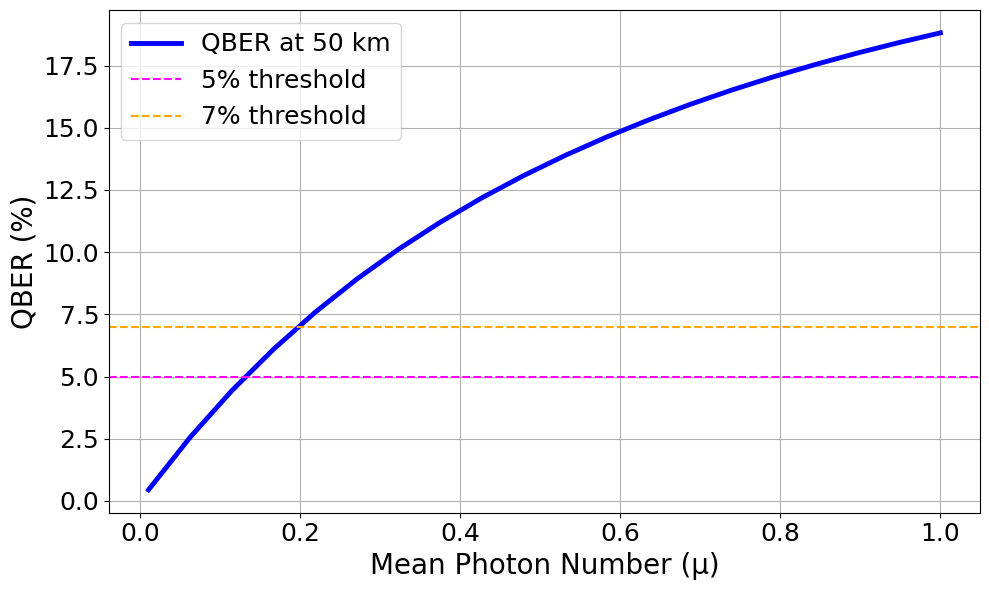

Optimal μ value for QBER in 5-7% range: 0.1663


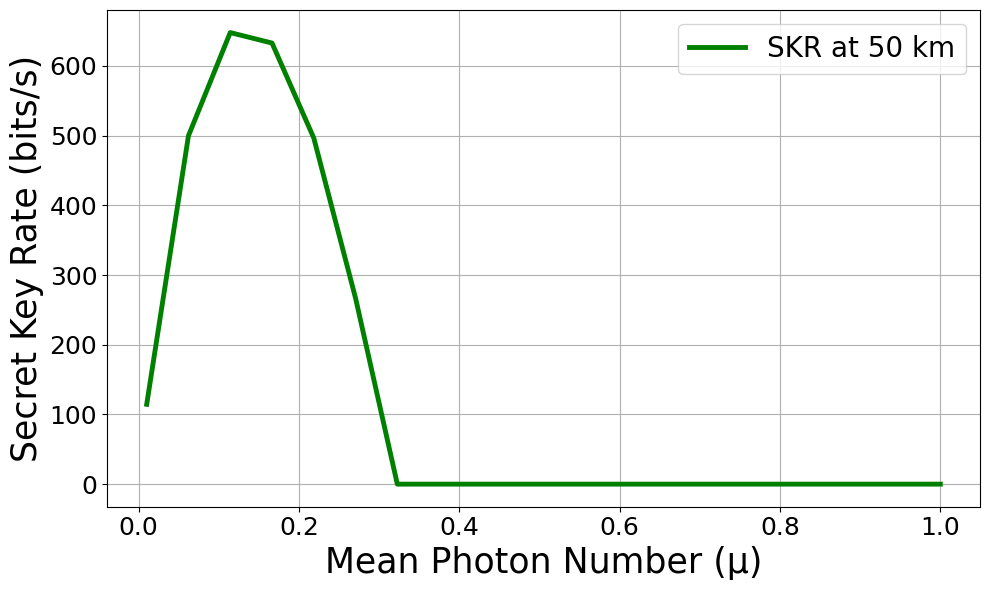

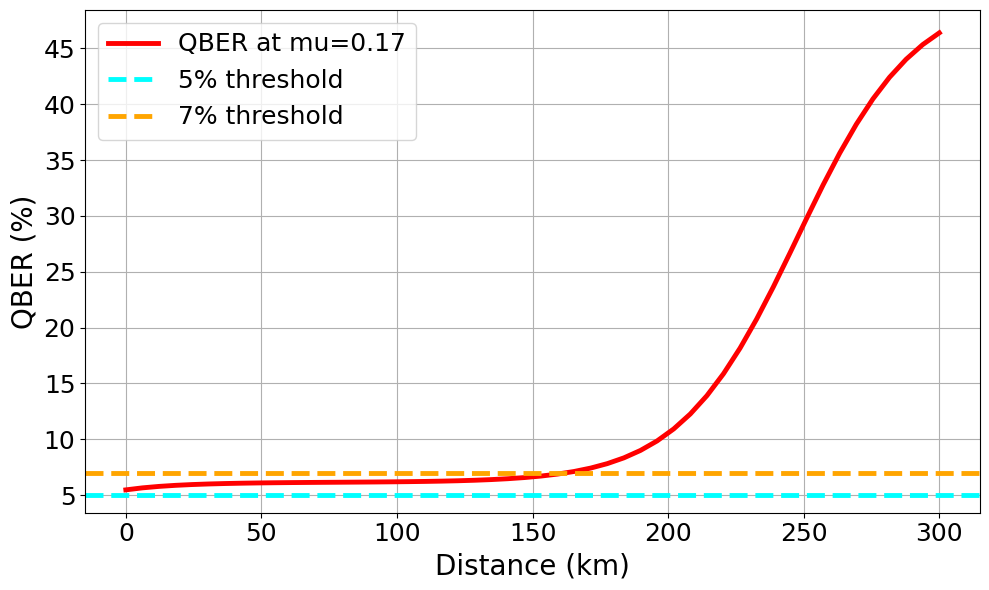

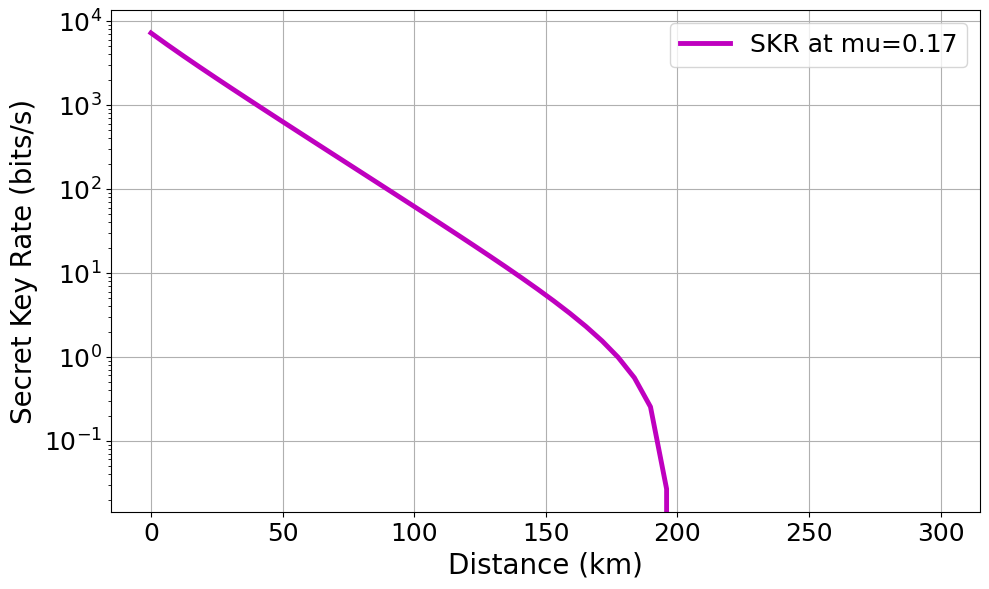

Max distance where QBER ≤ 11% (theoretical limit for secure key) is 19


In [6]:
print("Running BBM92 QKD Protocol Simulation in Fiber mode...")
    
# Initial parameters 
tw = 1e-9
alice_detector_eff = 0.80
bob_detector_eff = 0.80
alice_channel_base_eff = 1.00  # Source is at Alice
bob_channel_base_eff = 0.3913
dark_cr = 1000  # 1000 counts per second
dist = 50  # kilometers
rr = 1000000   # Default repetition rate: 1 MHz
# Define μ range for QBER vs mu and SKR vs mu plots
mu_val = np.linspace(0.01, 1.0, 20)
ch = "fiber"  # Channel mode can be "fiber" or "free-space"

# Plot QBER vs μ at the fixed distance
mu_values, qber_values = plot_qber_vs_mu(mu_val, tw, dist,
                                    alice_detector_eff,
                                    bob_detector_eff,
                                    alice_channel_base_eff,
                                    bob_channel_base_eff,
                                    dark_cr)

# Identify optimal μ value where QBER is within 5-7% range
optimal_indices = [i for i, qber in enumerate(qber_values) if 5 <= qber <= 7]
if optimal_indices:
    optimal_mu = mu_values[optimal_indices[len(optimal_indices)//2]]
    print(f"Optimal μ value for QBER in 5-7% range: {optimal_mu:.4f}")
else:
    optimal_mu = mu_values[np.argmin(np.abs(np.array(qber_values) - 6))]
    print(f"No μ value gives exactly 5-7% QBER. Closest value: {optimal_mu:.4f}")

# Plot SKR vs μ at the fixed distance
plot_skr_vs_mu(mu_values=mu_values, time_window=tw, distance=dist,
                                    alice_detector_efficiency=alice_detector_eff,
                                    bob_detector_efficiency=bob_detector_eff,
                                    channel_mode=ch,
                                    alice_channel_base_efficiency=alice_channel_base_eff,
                                    bob_channel_base_efficiency=bob_channel_base_eff,
                                    dark_count_rate=dark_cr,
                                    repetition_rate=rr)

# Define distance range for QBER vs distance and SKR vs distance plots
distance_values_qber = np.linspace(0, 300, 50)

# Plot QBER vs distance at the optimal μ
plot_qber_vs_distance(distance_values=distance_values_qber, time_window=tw, mu=optimal_mu,
                                    alice_detector_efficiency=alice_detector_eff,
                                    bob_detector_efficiency=bob_detector_eff,
                                    channel_mode=ch,
                                    alice_channel_base_efficiency=alice_channel_base_eff,
                                    bob_channel_base_efficiency=bob_channel_base_eff,
                                    dark_count_rate=dark_cr)

distance_values_skr = np.linspace(0, 300, 50)

# Plot SKR vs distance at the optimal μ
plot_skr_vs_distance(distance_values=distance_values_skr, time_window=tw, repetition_rate=rr, mu=optimal_mu,
                                    alice_detector_efficiency=alice_detector_eff,
                                    bob_detector_efficiency=bob_detector_eff,
                                    channel_mode=ch,
                                    alice_channel_base_efficiency=alice_channel_base_eff,
                                    bob_channel_base_efficiency=bob_channel_base_eff,
                                    dark_count_rate=dark_cr)

# Find max distance where QBER ≤ 11% (theoretical limit for secure key)
simulator = BBM92Simulator(
    mu=optimal_mu,
    alice_detector_efficiency=alice_detector_eff,
    bob_detector_efficiency=bob_detector_eff,
    alice_channel_base_efficiency=alice_channel_base_eff,
    bob_channel_base_efficiency=bob_channel_base_eff,
    dark_count_rate=dark_cr,
    time_window=tw,
    channel_mode="fiber"
)

max_distance = 0
for d in np.arange(0, 20, 1):
    simulator.update_distance(d)
    qber = simulator.calculate_qber()
    if qber <= 11:
        max_distance = d
    else:
        break

# Display results for optimal μ at the fixed distance
simulator.update_distance(dist)
optimal_qber = simulator.calculate_qber()
optimal_skr = simulator.calculate_skr(1000)

print(f"Max distance where QBER ≤ 11% (theoretical limit for secure key) is {max_distance}")

Running BBM92 QKD Protocol Simulation in FSO mode...


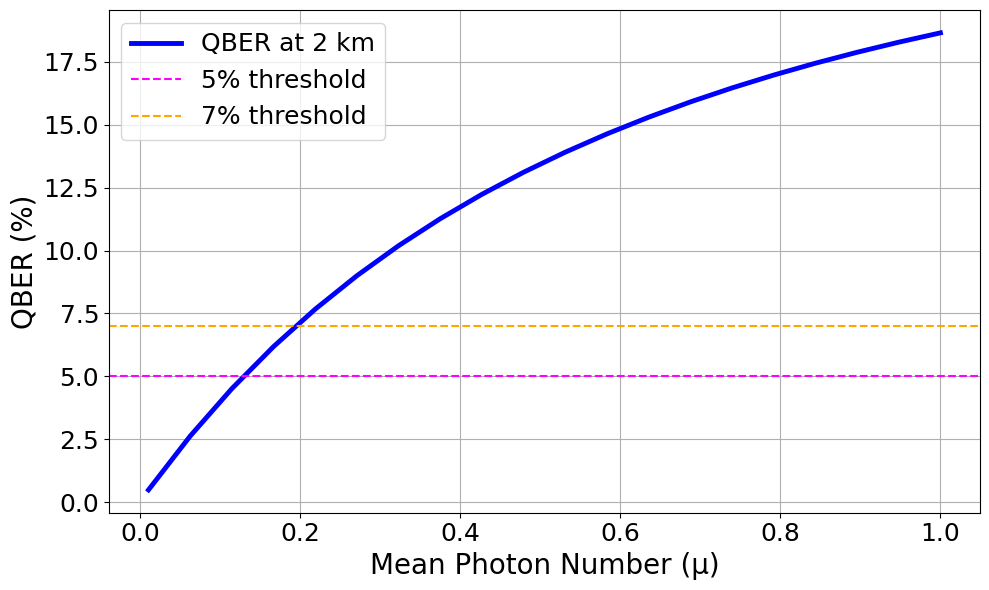

Optimal μ value for QBER in 5-7% range: 0.1663


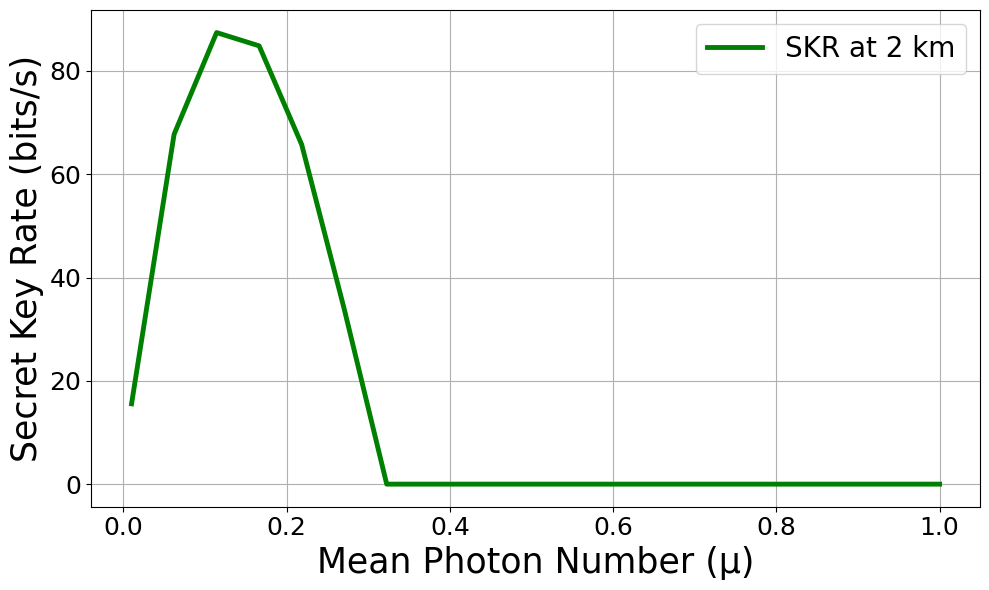

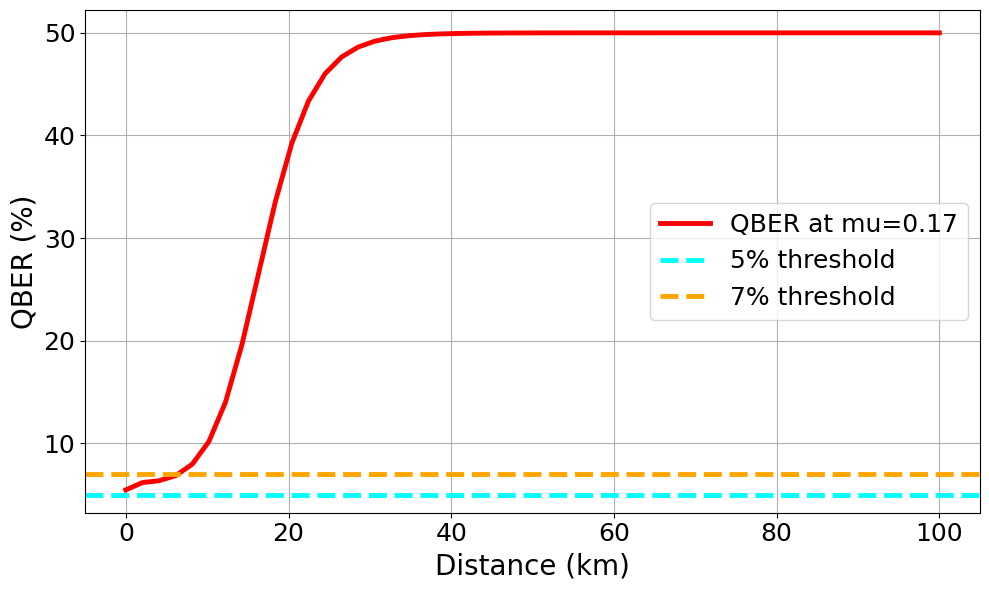

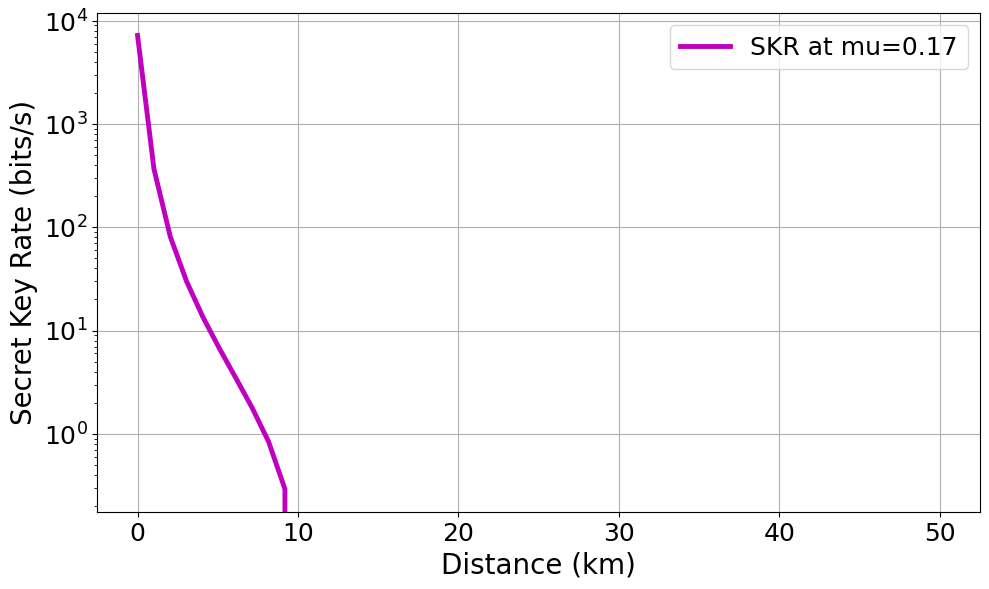

Max distance where QBER ≤ 11% (theoretical limit for secure key) is 10


In [8]:
print("Running BBM92 QKD Protocol Simulation in FSO mode...")
    
# Initial parameters 
tw = 1e-9
alice_detector_eff = 0.80
bob_detector_eff = 0.80
alice_channel_base_eff = 1.00  # Source is at Alice
bob_channel_base_eff = 0.3913
dark_cr = 1000  # 1000 counts per second
dist = 2  # kilometers
rr = 1000000   # Default repetition rate: 1 MHz
# Define μ range for QBER vs mu and SKR vs mu plots
mu_val = np.linspace(0.01, 1.0, 20)
ch = "fso"  # Channel mode can be "fiber" or "free-space"

# Plot QBER vs μ at the fixed distance
mu_values, qber_values = plot_qber_vs_mu(mu_values=mu_val, time_window=tw, distance=dist,
                                    alice_detector_efficiency=alice_detector_eff,
                                    bob_detector_efficiency=bob_detector_eff,
                                    channel_mode=ch,
                                    alice_channel_base_efficiency=alice_channel_base_eff,
                                    bob_channel_base_efficiency=bob_channel_base_eff,
                                    dark_count_rate=dark_cr)

# Identify optimal μ value where QBER is within 5-7% range
optimal_indices = [i for i, qber in enumerate(qber_values) if 5 <= qber <= 7]
if optimal_indices:
    optimal_mu = mu_values[optimal_indices[len(optimal_indices)//2]]
    print(f"Optimal μ value for QBER in 5-7% range: {optimal_mu:.4f}")
else:
    optimal_mu = mu_values[np.argmin(np.abs(np.array(qber_values) - 6))]
    print(f"No μ value gives exactly 5-7% QBER. Closest value: {optimal_mu:.4f}")

# Plot SKR vs μ at the fixed distance
plot_skr_vs_mu(mu_values=mu_values, time_window=tw, distance=dist,
                                    alice_detector_efficiency=alice_detector_eff,
                                    bob_detector_efficiency=bob_detector_eff,
                                    channel_mode=ch,
                                    alice_channel_base_efficiency=alice_channel_base_eff,
                                    bob_channel_base_efficiency=bob_channel_base_eff,
                                    dark_count_rate=dark_cr,
                                    repetition_rate=rr)

# Define distance range for QBER vs distance and SKR vs distance plots
distance_values_qber = np.linspace(0, 100, 50)

# Plot QBER vs distance at the optimal μ
plot_qber_vs_distance(distance_values=distance_values_qber, time_window=tw, mu=optimal_mu,
                                    alice_detector_efficiency=alice_detector_eff,
                                    bob_detector_efficiency=bob_detector_eff,
                                    channel_mode=ch,
                                    alice_channel_base_efficiency=alice_channel_base_eff,
                                    bob_channel_base_efficiency=bob_channel_base_eff,
                                    dark_count_rate=dark_cr)

distance_values_skr = np.linspace(0, 50, 50)

# Plot SKR vs distance at the optimal μ
plot_skr_vs_distance(distance_values=distance_values_skr, time_window=tw, repetition_rate=rr, mu=optimal_mu,
                                    alice_detector_efficiency=alice_detector_eff,
                                    bob_detector_efficiency=bob_detector_eff,
                                    channel_mode=ch,
                                    alice_channel_base_efficiency=alice_channel_base_eff,
                                    bob_channel_base_efficiency=bob_channel_base_eff,
                                    dark_count_rate=dark_cr)

# Find max distance where QBER ≤ 11% (theoretical limit for secure key)
simulator = BBM92Simulator(
    mu=optimal_mu,
    alice_detector_efficiency=alice_detector_eff,
    bob_detector_efficiency=bob_detector_eff,
    alice_channel_base_efficiency=alice_channel_base_eff,
    bob_channel_base_efficiency=bob_channel_base_eff,
    dark_count_rate=dark_cr,
    time_window=tw,
    channel_mode=ch
)

max_distance = 0
for d in np.arange(0, 20, 1):
    simulator.update_distance(d)
    qber = simulator.calculate_qber()
    if qber <= 11:
        max_distance = d
    else:
        break

# Display results for optimal μ at the fixed distance
simulator.update_distance(dist)
optimal_qber = simulator.calculate_qber()
optimal_skr = simulator.calculate_skr(1000)

print(f"Max distance where QBER ≤ 11% (theoretical limit for secure key) is {max_distance}")

# 7. Conclusion and Future Directions

In this notebook, we have developed and demonstrated a detailed simulator for the BBM92 Quantum Key Distribution (QKD) protocol. The simulator integrates realistic models for the photon source, quantum channel, and single-photon detectors, and provides a comprehensive framework for analyzing key performance metrics such as the Quantum Bit Error Rate (QBER) and Secret Key Rate (SKR).

By visualizing how QBER and SKR depend on the mean photon number and channel distance, users can gain valuable insights into the optimization of QKD systems. The simulation results help identify operational regimes where secure key generation is feasible and efficient, and where losses or errors may become prohibitive. The modular structure of the code enables easy adaptation for additional studies or modifications.

---

## Future Directions

There are several promising avenues to extend this work:

- **Advanced Source Modeling**  
  Incorporate other photon sources (such as weak coherent pulses) and compare their performance to SPDC sources.

- **More Realistic Channel Models**  
  Add effects such as polarization drift, time-varying losses, or atmospheric turbulence for free-space channels.

- **Detector Improvements**  
  Model more complex detector behaviors, including afterpulsing, dead time, and multi-pixel detection.

- **Eavesdropping Strategies**  
  Simulate more sophisticated attacks (e.g., photon number splitting, Trojan horse, side channels) and analyze their impact on QBER and SKR.

- **Finite-Key Analysis**  
  Move beyond asymptotic formulas to include statistical fluctuations for short key lengths.

- **Protocol Extensions**  
  Adapt the simulator for other entanglement-based protocols (e.g., E91, device-independent QKD) or decoy-state protocols.

- **Experimental Data Integration**  
  Allow the simulator to incorporate and compare with real experimental data.
